In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
# sklearn stuff
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

#yellobrick stuff
from yellowbrick.classifier import ConfusionMatrix, DiscriminationThreshold, PrecisionRecallCurve, ClassificationReport, ClassPredictionError, ROCAUC
from yellowbrick.target import ClassBalance
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [5]:
def analyze_classifier(model,
                       X_train,
                       X_test,
                       y_train,
                       y_test,
                       response='Response',
                       classes=[0, 1, 2]):
    matrix = ConfusionMatrix(model, classes=classes)
    matrix.fit(X_train, y_train[response])
    matrix.score(X_test, y_test[response])
    matrix.show()
    class_report = ClassificationReport(model, classes=classes, support=True)
    class_report.fit(X_train, y_train[response])
    class_report.score(X_test, y_test[response])
    class_report.show()
    roc_auc = ROCAUC(model, classes=classes)
    roc_auc.fit(X_train, y_train[response])
    roc_auc.score(X_test, y_test[response])
    roc_auc.show()
    recall = PrecisionRecallCurve(model)
    recall.fit(X_train, y_train)
    recall.score(X_test, y_test)
    recall.show()
    if len(classes) == 2:
        disc_thresh = DiscriminationThreshold(model)
        disc_thresh.fit(X_train, y_train.values.ravel())
        disc_thresh.show()
        return disc_thresh.thresholds_, disc_thresh.cv_scores_
    else:
        return None, None


def sklearn_vif(exogs, data):

    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}

    # form input data for each exogenous variable
    for exog in exogs:
        #print(exog)
        not_exog = [i for i in exogs if i != exog]
        #print(not_exog)
        X, y = data[not_exog], data[exog]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[exog] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[exog] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def compute_new_conf_matrix(predictions, probabilities, cutoff, y_test):
    #create a df of predictions and probabilities
    predictions = pd.DataFrame(list(predictions), columns=['Predict'])
    predicted_probs = pd.concat([
        pd.DataFrame(list(probabilities), columns=['ProbFalse', 'ProbTrue']),
        predictions
    ],
                                axis=1)
    #make array of values where val > cutoff
    predicted_probs['NewPredict'] = predicted_probs['ProbTrue'].apply(
        lambda x: 1 if x >= cutoff else 0)
    matrix = pd.DataFrame(confusion_matrix(y_test, predicted_probs.NewPredict))
    matrix.rename(columns={
        0: 'No_Predicted',
        1: 'Yes_Predicted'
    },
                  index={
                      0: 'No_True',
                      1: 'Yes_True'
                  },
                  inplace=True)
    return round(accuracy_score(y_test, predicted_probs.NewPredict),
                 5), matrix, predicted_probs

### Load/Clean Data

In [6]:
data = pd.read_csv('ABNB_NY_V2.csv')
summary = data.describe()
print({x: len(data[x].unique()) for x in data.columns})
summary

{'id': 48895, 'name': 47897, 'host_id': 37457, 'host_name': 11453, 'neighbourhood_group': 5, 'neighbourhood': 221, 'latitude': 19048, 'longitude': 14718, 'room_type': 3, 'price': 674, 'minimum_nights': 109, 'number_of_reviews': 394, 'last_review': 1765, 'reviews_per_month': 938, 'calculated_host_listings_count': 47, 'availability_365': 366, 'ZIP': 199, 'dist_subway': 46157, 'cnt_all': 133, 'cnt_entire_home': 95, 'cnt_private_room': 74, 'cnt_shared_room': 14, 'avgprice_all': 1912, 'avgprice_entire_home': 1409, 'avgprice_private_room': 1309, 'avgprice_shared_room': 219}


,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,ZIP,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48871.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,10675.111211,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,599.591915,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,10001.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,10024.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,11104.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,11221.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,11697.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000


In [7]:
print(data['neighbourhood_group'].unique())
print(data['room_type'].unique())
len(data[data['last_review'].isna()])

['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
['Private room' 'Entire home/apt' 'Shared room']


10052

### Convert Features to Types

In [8]:
data['price'] = data['price'].astype('float')
data['minimum_nights'] = data['minimum_nights'].astype('float')
data['number_of_reviews'] = data['number_of_reviews'].astype('float')
data['calculated_host_listings_count'] = data[
    'calculated_host_listings_count'].astype('float')
data['availability_365'] = data['availability_365'].astype('float')
data['dist_subway'] = data['dist_subway'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_all'] = data['cnt_all'].astype('float')
data['cnt_entire_home'] = data['cnt_entire_home'].astype('float')
data['cnt_private_room'] = data['cnt_private_room'].astype('float')
data['cnt_shared_room'] = data['cnt_shared_room'].astype('float')
data['avgprice_all'] = data['avgprice_all'].astype('float')
data['avgprice_entire_home'] = data['avgprice_entire_home'].astype('float')
data['avgprice_private_room'] = data['avgprice_private_room'].astype('float')
data['avgprice_shared_room'] = data['avgprice_shared_room'].astype('float')
data['neighbourhood_group'] = data['neighbourhood_group'].astype('category')
data['neighbourhood'] = data['neighbourhood'].astype('category')
data['ZIP'] = data['ZIP'].astype('category')
data['last_review'] = pd.to_datetime(data['last_review'])

In [9]:
data['days_since_last_review'] = (
    dt.datetime.strptime('2020-01-01', '%Y-%m-%d') -
    data['last_review']).dt.days
data.days_since_last_review.fillna(data.days_since_last_review.max(),
                                   inplace=True)
data.drop(columns=['last_review'], inplace=True)

### Drop useless cols

In [10]:
data.drop(
    columns=['id', 'name', 'host_id', 'host_name', 'neighbourhood', 'ZIP'],
    inplace=True)

In [11]:
data.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,dist_subway,cnt_all,cnt_entire_home,cnt_private_room,cnt_shared_room,avgprice_all,avgprice_entire_home,avgprice_private_room,avgprice_shared_room,days_since_last_review
count,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327,0.245997,52.815768,29.719726,22.013396,1.082646,152.703409,191.493067,98.024409,40.581520,1018.678331
std,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289,0.346640,43.303548,29.254144,18.668278,2.615105,90.678742,114.468382,73.981026,93.479089,1169.872743
min,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000,0.000553,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,177.000000
25%,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000,0.103457,20.000000,8.000000,7.000000,0.000000,94.812500,137.250000,64.500000,0.000000,196.000000
50%,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000,0.173022,43.000000,20.000000,17.000000,0.000000,135.208333,180.850000,83.666667,0.000000,363.000000
75%,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000,0.269066,73.000000,42.000000,33.000000,1.000000,189.000000,231.264463,111.500000,60.000000,1378.000000
max,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,4.931115,230.000000,142.000000,91.000000,26.000000,5000.000000,5000.000000,3000.000000,1800.000000,3201.000000


### Define feature set

In [12]:
data.dtypes
target_col = 'room_type'

#### Price Outliers 

- Drop stuff with zero price

- Drop anything with price >= 300

In [13]:
data = data[data.price != 0].copy()

In [14]:
data = data[data.price < 300].copy()

In [15]:
data = data[data.minimum_nights <= 20].copy()
data.to_csv('airbnb_clean.csv', index=False)

### Add Response Column

In [16]:
room_types = {'Entire home/apt': 0, 'Private room': 1, 'Shared room': 2}
data['Response'] = data.apply(lambda x: room_types[x.room_type], axis=1)
#data.drop(axis=0, labels=[x for x in data.index if data.iloc[x].Response == 2], inplace=True)

In [17]:
data.dtypes[data.dtypes == np.float64].index

Index(['latitude', 'longitude', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'dist_subway', 'cnt_all', 'cnt_entire_home',
       'cnt_private_room', 'cnt_shared_room', 'avgprice_all',
       'avgprice_entire_home', 'avgprice_private_room', 'avgprice_shared_room',
       'days_since_last_review'],
      dtype='object')

In [18]:
data.dtypes[data.dtypes == 'category']

neighbourhood_group    category
dtype: object

### Feature / Target Split

In [19]:
data_final = data
features, target = data_final.drop(
    columns=['Response']), data_final.loc[:, ['Response']]
features.shape, target.shape

((40180, 20), (40180, 1))

### Train/Test Split

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x00000228DDE29448>,
             colormap=None, colors=None,
             labels=['Entire home/apt', 'Private room', 'Shared room'])

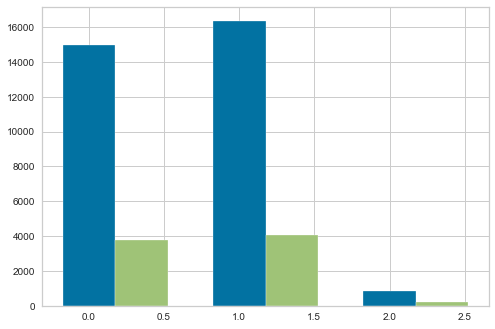

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=0.2,
                                                    random_state=0)
classes_test = ClassBalance(
    labels=['Entire home/apt', 'Private room', 'Shared room'])
classes_test.fit(y_train['Response'], y_test['Response'])

### Data Transforms

    - OHE Encode all categoricals
    - Standard Scale all numerics (sklearn is not R - it does not do this by default)
    - This needs to be done on train/test set separately (create a pipeline) 
    
    https://scikit-learn.org/stable/modules/cross_validation.html
    
    https://scikit-learn.org/stable/modules/compose.html#combining-estimators

In [21]:
#OH encode
label_encode = [
    x for x, y in dict(X_train.dtypes).items()
    if type(y) == pd.CategoricalDtype
]
for var in label_encode:
    #impute to Mode
    print(f"{var} was OHE'd")
    X_train[var].fillna(X_train[var].mode()[0], inplace=True)
    X_test[var].fillna(X_train[var].mode()[0], inplace=True)
    cat_list_train = pd.get_dummies(X_train[var], prefix=var)
    cat_list_test = pd.get_dummies(X_test[var], prefix=var)
    X_train_new = X_train.join(cat_list_train)
    X_train = X_train_new
    X_test_new = X_test.join(cat_list_test)
    X_test = X_test_new

normalize = [x for x, y in dict(X_train.dtypes).items() if y == np.float64]
for col in normalize:
    #change impution scheme?
    print(f"{col} was Standard Scaled")
    X_train[col].fillna(X_train[col].median(), inplace=True)
    X_test[col].fillna(X_train[col].median(), inplace=True)
    normalizer = StandardScaler()
    ar_train = X_train[col].to_numpy().reshape(-1, 1)
    normalizer.fit(ar_train)
    X_train.loc[:, col] = normalizer.transform(ar_train)
    ar_test = X_test[col].to_numpy().reshape(-1, 1)
    X_test.loc[:, col] = normalizer.transform(ar_test)

X_train.drop(columns=label_encode, inplace=True)
X_test.drop(columns=label_encode, inplace=True)
X_train.drop(columns=target_col, inplace=True)
X_test.drop(columns=target_col, inplace=True)

neighbourhood_group was OHE'd
latitude was Standard Scaled
longitude was Standard Scaled
price was Standard Scaled
minimum_nights was Standard Scaled
number_of_reviews was Standard Scaled
reviews_per_month was Standard Scaled
calculated_host_listings_count was Standard Scaled
availability_365 was Standard Scaled
dist_subway was Standard Scaled
cnt_all was Standard Scaled
cnt_entire_home was Standard Scaled
cnt_private_room was Standard Scaled
cnt_shared_room was Standard Scaled
avgprice_all was Standard Scaled
avgprice_entire_home was Standard Scaled
avgprice_private_room was Standard Scaled
avgprice_shared_room was Standard Scaled
days_since_last_review was Standard Scaled


c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


### Baseline accuracy rates

In [22]:
base_line_accuracy_train = {
    'class_0': (y_train[y_train.Response == 0].shape[0] / y_train.shape[0]),
    'class_1': (y_train[y_train.Response == 1].shape[0] / y_train.shape[0]),
    'class_2': (y_train[y_train.Response == 2].shape[0] / y_train.shape[0])
}
base_line_accuracy_test = {
    'class_0': (y_test[y_test.Response == 0].shape[0] / y_test.shape[0]),
    'class_1': (y_test[y_test.Response == 1].shape[0] / y_test.shape[0]),
    'class_2': (y_test[y_test.Response == 2].shape[0] / y_test.shape[0])
}

print(base_line_accuracy_train)
print(base_line_accuracy_test)

{'class_0': 0.46599676455948236, 'class_1': 0.5083685913389746, 'class_2': 0.025634644101543057}
{'class_0': 0.4682677949228472, 'class_1': 0.5068442010950722, 'class_2': 0.024888003982080638}


## Create Models (50 Pts)

	Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe. 

In [23]:
?LogisticRegression

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

### Fit a Logistic on all predictors

- Using standard techniques in scikit-learn, we will attempt to isolate the best parameters for:
    - Inverse of regularization strength (C): 
        - lower values imply stronger regularization penalty and slower fit times
    - Tolerance (tol):
        - tolerance for stopping criteria

In [ ]:
logistic = LogisticRegression(
     max_iter=10000
    ,fit_intercept=True # always fit an intercept term
    ,n_jobs=-1 # use all processors
)
pipe = Pipeline(steps=[('logistic', logistic)])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'logistic__C': np.logspace(-4, 4, 4),
    'logistic__class_weight':[None, 'balanced'],
    'logistic__penalty':['l1', 'l2','elasticnet', 'none'],
    'logistic__multi_class':['auto', 'ovr', 'multinomial'],
    'logistic__dual':[True, False],
    'logistic__solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train, y_train.values.ravel())
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
results = pd.DataFrame(search.cv_results_)
results

### Analyzing the Logistic Classifier With Parameters Specified

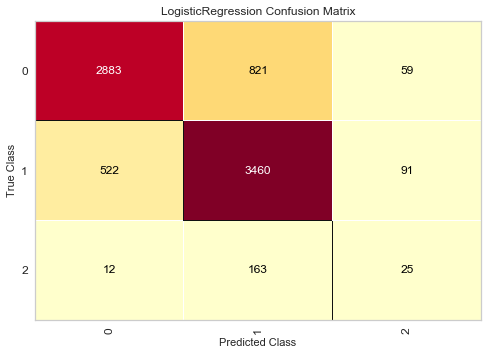

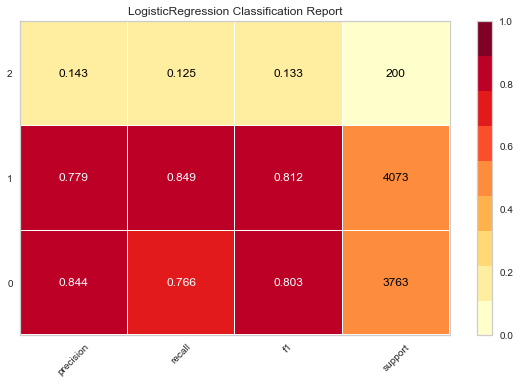

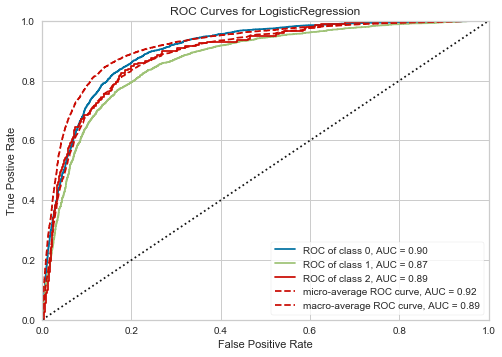

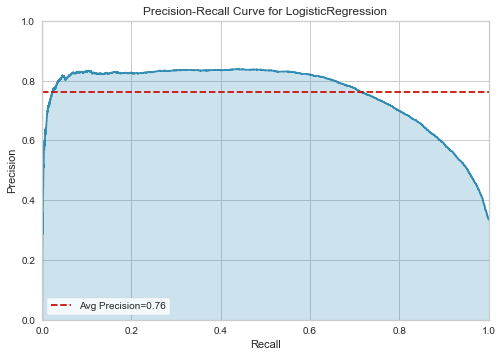

Logit (all features) Accuracy 0.79243


In [21]:
lgrg_all = LogisticRegression(
    C=.001,
    solver='liblinear',
    dual=False,
    fit_intercept=True,
    intercept_scaling=1
    #, l1_ratio=None
    ,
    max_iter=100,
    multi_class='auto',
    n_jobs=None,
    penalty='l2',
    random_state=0,
    tol=0.0001,
    verbose=0,
    class_weight='balanced',
    warm_start=False)

lgrg_all.fit(X_train, y_train.values.ravel())
cutoffs_lgrg_all, scores_lgrg_all = analyze_classifier(lgrg_all, X_train,
                                                       X_test, y_train, y_test)
predict_logit_all = lgrg_all.predict(X_test)
prob_logit_all = lgrg_all.predict_proba(X_test)
acc_logit_all = round(accuracy_score(y_test, predict_logit_all), 5)
print(f'Logit (all features) Accuracy {acc_logit_all}')
lgrg_all.coef_

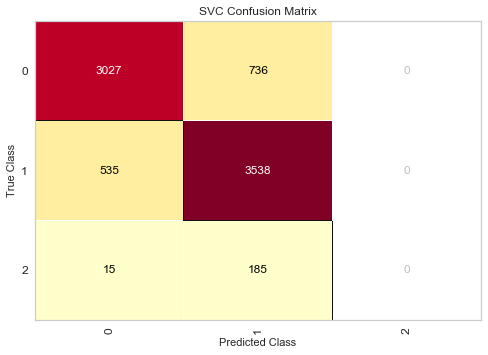

c:\users\skennedy\.virtualenvs\lab1-chmlaxk4\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


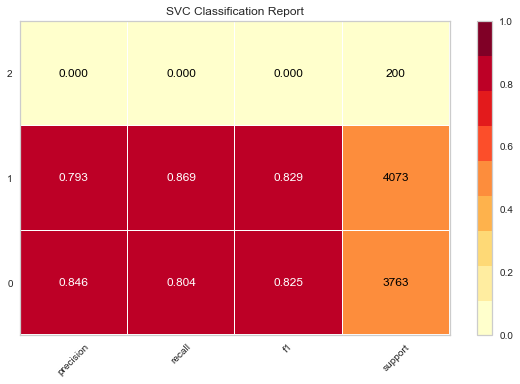

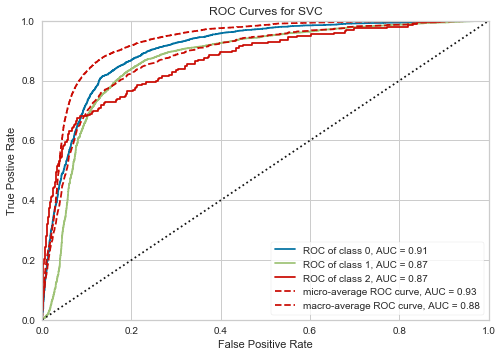

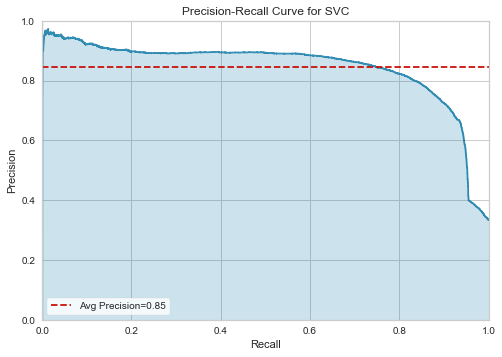

(None, None)

In [22]:
from sklearn.svm import SVC
support_vec_model = SVC(gamma='auto', kernel='linear', C=0.01)
support_vec_model.fit(X_train, y_train.values.ravel())
analyze_classifier(support_vec_model, X_train, X_test, y_train, y_test)

### Random forest classifier

 - adding feature imporance analysis
 
 https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

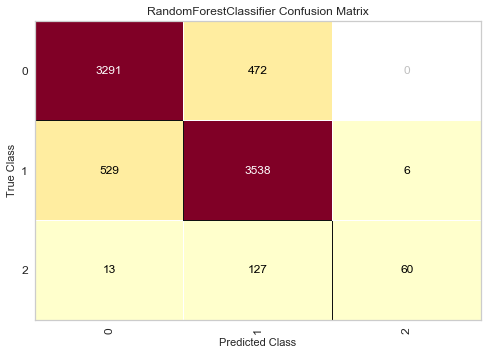

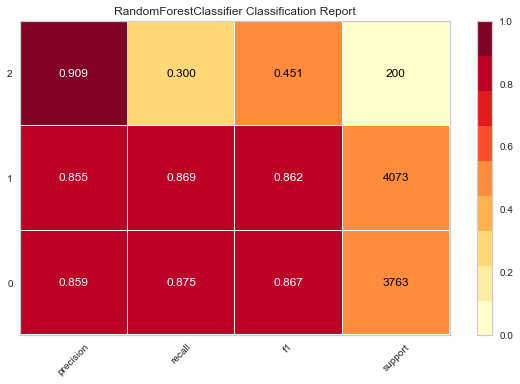

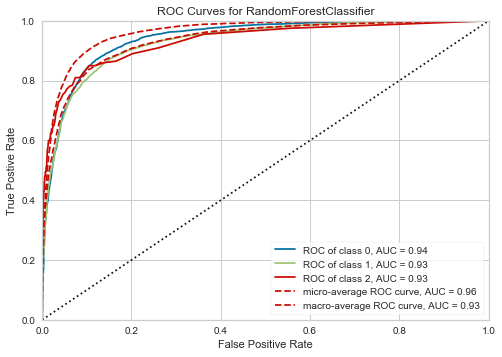

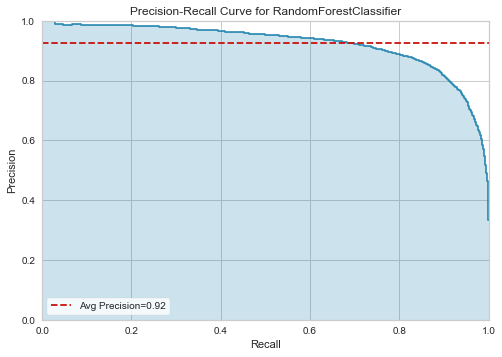

RF Accuracy 0.85727


In [23]:
rf_classifier = RandomForestClassifier(
    #max_depth=None,
    random_state=0,
    #bootstrap=True,
    #oob_score=True,
    #max_samples = 50,
    criterion='gini',
    n_estimators=200)
rf_classifier.fit(X_train, y_train.values.ravel())
cutoffs_rf, scores_rf = analyze_classifier(rf_classifier, X_train, X_test,
                                           y_train, y_test)
predict_rf = rf_classifier.predict(X_test)
prob_rf = rf_classifier.predict_proba(X_test)
acc_rf = round(accuracy_score(y_test, predict_rf), 5)
print(f'RF Accuracy {acc_rf}')

Feature ranking:
1:latitude 0.38412
2:longitude 0.04932
3:price 0.04502
4:minimum_nights 0.04465
5:number_of_reviews 0.04366
6:reviews_per_month 0.04255
7:calculated_host_listings_count 0.04173
8:availability_365 0.03891
9:dist_subway 0.03822
10:cnt_all 0.03672
11:cnt_entire_home 0.03507
12:cnt_private_room 0.03455
13:cnt_shared_room 0.03332
14:avgprice_all 0.03294
15:avgprice_entire_home 0.03109
16:avgprice_private_room 0.02611
17:avgprice_shared_room 0.01854
18:days_since_last_review 0.01418
19:neighbourhood_group_Bronx 0.00402
20:neighbourhood_group_Brooklyn 0.00303
21:neighbourhood_group_Manhattan 0.00151
22:neighbourhood_group_Queens 0.00054
23:neighbourhood_group_Staten Island 0.00021


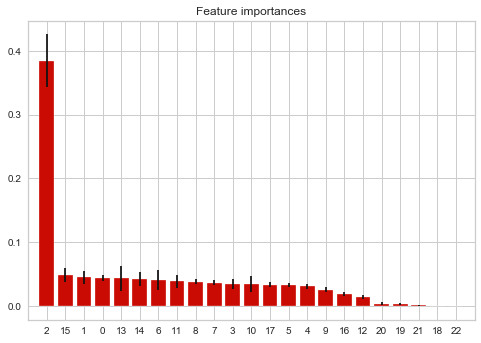

In [24]:
importances = rf_classifier.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_classifier.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print(f'{f+1}:{X_train.columns[f]} {importances[indices[f]]:.5f}')

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]),
        importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### PCA Pipeline

https://scikit-learn.org/stable/auto_examples/compose/plot_digits_pipe.html

Best parameter (CV score=0.811):
{'logistic__C': 21.54434690031882, 'pca__n_components': 18}


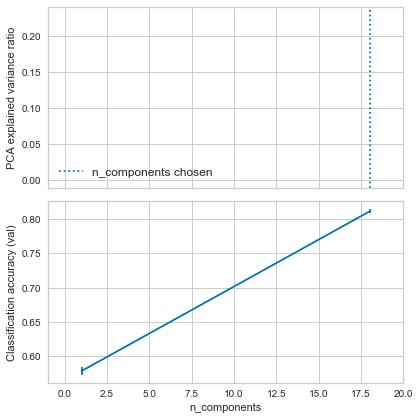

In [25]:
# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression(max_iter=10000, tol=0.1)
pipe = Pipeline(steps=[('pre-process',
                        StandardScaler()), ('pca', pca), ('logistic',
                                                          logistic)])
#Continuous predictors only
continuous = X_train.dtypes[X_train.dtypes == 'float64'].index

# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'pca__n_components': [1, len(continuous)],
    'logistic__C': np.logspace(-4, 4, 4),
}
search = GridSearchCV(pipe, param_grid, n_jobs=-1)
search.fit(X_train[continuous], y_train.values.ravel())
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

# Plot the PCA spectrum
pca.fit(X_train[continuous])

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_ratio_,
         '+',
         linewidth=2)
ax0.set_ylabel('PCA explained variance ratio')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':',
            label='n_components chosen')
ax0.legend(prop=dict(size=12))

# For each number of components, find the best classifier results
results = pd.DataFrame(search.cv_results_)
components_col = 'param_pca__n_components'
best_clfs = results.groupby(components_col).apply(
    lambda g: g.nlargest(1, 'mean_test_score'))

best_clfs.plot(x=components_col,
               y='mean_test_score',
               yerr='std_test_score',
               legend=False,
               ax=ax1)
ax1.set_ylabel('Classification accuracy (val)')
ax1.set_xlabel('n_components')

plt.xlim(-1, 20)

plt.tight_layout()
plt.show()

In [26]:
pca.explained_variance_ratio_.sum()

1.0000000000000002

In [27]:
pca.explained_variance_

array([4.13141036e+00, 2.07228705e+00, 1.85283064e+00, 1.25368266e+00,
       1.10602252e+00, 1.01799043e+00, 9.40260808e-01, 8.27869904e-01,
       7.98727313e-01, 7.50293138e-01, 7.26418293e-01, 6.71988053e-01,
       6.26219955e-01, 4.43518388e-01, 4.02881222e-01, 3.10747264e-01,
       6.74120047e-02, 4.13401871e-31])

In [28]:
pca.explained_variance_ratio_

array([2.29515657e-01, 1.15123477e-01, 1.02931833e-01, 6.96468697e-02,
       6.14437837e-02, 5.65532647e-02, 5.22350864e-02, 4.59913416e-02,
       4.43723591e-02, 4.16816553e-02, 4.03553163e-02, 3.73315082e-02,
       3.47889152e-02, 2.46391439e-02, 2.23815938e-02, 1.72631998e-02,
       3.74499486e-03, 2.29660561e-32])

In [29]:
pca.n_features_

18

In [30]:
pca.n_components_

18

In [31]:
len(pca.components_[0])

18

### Pipeline Hyperparameter Tuning

https://towardsdatascience.com/logistic-regression-model-tuning-with-scikit-learn-part-1-425142e01af5

In [32]:
pipe = Pipeline(steps=[('classifier', RandomForestClassifier())
                       ])  #RF here is just a dummy

param_grid = [{
    'classifier': [LogisticRegression()],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': np.logspace(-4, 4, 20),
    'classifier__solver': ['liblinear']
}, {
    'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': list(range(10, 101, 10)),
    'classifier__max_features': list(range(6, 32, 5))
}]

clf = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)
best_clf = clf.fit(X_train, y_train.values.ravel())

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 224 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 474 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.3min finished


In [34]:
best_clf.best_estimator_

Pipeline(memory=None,
         steps=[('classifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features=16,
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=None,
                                        verbose=0, warm_start=False))],
         verbose=False)

### Feature Importance

https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html#sklearn.inspection.permutation_importance